ICI oN a 1 NN par niveau de bruit : 
+ pas de probleme de plage de sortie. 
- plus long et pas de notion de sigma continue on peut pas interpoler à des sigmas plus faible... 

In [1]:
import torch
import torch.distributions as dist
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:
BASE_PATH = os.getcwd()
WEIGHTS_PATH = BASE_PATH + '/weights/multiple'


In [3]:
torch.set_default_dtype(torch.float32)


if torch.mps.is_available():
    device = torch.device('mps')
    dtype = torch.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor
    
def t(x):
    # j'avais des problèmes de type avec les long 
    return torch.as_tensor(x, dtype=torch.get_default_dtype()).to(device)

print(device)


mps


In [4]:
mean = torch.stack(
    [
    t([-4,4]), # mean Gauss 1 
    t([4,-4]),  # mean Gauss 2 
    t([0,0])
    ]
    ,dim = 0
).to(device)

cov = torch.stack(
    [
        torch.eye(2)/10, # cov 
        torch.eye(2),  #cov 2
        torch.eye(2)/40
    ],
    dim = 0
).to(device)

weights = dist.Categorical(t([0.1,0.6,0.3]))
gaussians = dist.MultivariateNormal(mean,cov)

dataset = dist.MixtureSameFamily(weights,gaussians)

In [5]:
class ScoreNetworkConditionned(nn.Module): 
    
    def __init__(self, x_dim,hidden_dim = 128*2,sigma_emb_dim=20):
        super().__init__()
        
        self.score_mlp = nn.Sequential(
            nn.Linear(x_dim ,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,x_dim)
        )
    def forward(self,x_noisy):
        score = self.score_mlp(x_noisy)
        return score
    
def LossNCSN(model,x,sigma,EPS_TRAINNING):
    
    B,x_dim = x.shape
    sigma = sigma.expand(B).unsqueeze(-1)
    eps = torch.randn_like(x).to(device)
    x_noisy = x + sigma* eps # donc B écahntillons bruité 
    if EPS_TRAINNING :
        f = model(x_noisy)           # f ≈ -eps
        loss = ((f + eps)**2).sum(dim=-1).mean()
        return loss
    else : 
        s = model(x_noisy)
        target = -eps/sigma
        loss = ((s-target)**2).sum(dim=-1).mean()
        return loss

def construct_noise_linspace(min,max,L):
    return torch.linspace(min,max,L).flip(0).to(device)

def construct_noise_logspace(sigma_min,sigma_max,L):
    return torch.logspace(
        torch.log10(t(sigma_min)),
        torch.log10(t(sigma_max)),L
    ).flip(0).to(device)

In [6]:
batch_size = 4*128
N_train = 20000
EPS_TRAINNING = False # soit on entraine le réseau à prédire le bruit eps soit on l'entraine à prédire le score`

x_dim = dataset.sample().shape[-1]
sigmas = construct_noise_logspace(1e-1,1e-1,1)
models = [ScoreNetworkConditionned(x_dim=x_dim,hidden_dim=128).to(device) for _ in range(len(sigmas))]
optimizers = [torch.optim.Adam(m.parameters(), lr=1e-3) for m in models]


In [7]:
i = 0
Ltot = []
LAST_PATH = ''
for m,opt in zip(models,optimizers) :
    
    # initialization avec le précédent
    # if i!=0 : 
    #     m.load_state_dict(torch.load(LAST_PATH, weights_only=True))
    m.train()
    L = [] # loss list
    sigma = sigmas[i]
    for step in range(N_train):
        x = dataset.sample((batch_size,)) # (B, x_dim)
        opt.zero_grad()
        loss = LossNCSN(m, x,sigma=sigma,EPS_TRAINNING=EPS_TRAINNING)
        loss.backward()
        opt.step()
        L.append(loss.item())
        
        if (step + 1) % 5000 == 0:
            LAST_PATH = os.path.join(WEIGHTS_PATH,f'{i}_current.pth')
            torch.save(m.state_dict(),LAST_PATH)
            print(f"[{step+1}/{N_train}] loss = {(np.mean(L[-500:])):.4f}")
        
    Ltot.append(L)
    print(f'finished trainning for sigma = {sigmas[i]}')
    i+=1     

[5000/20000] loss = 179.7707
[10000/20000] loss = 180.1868
[15000/20000] loss = 180.0805
[20000/20000] loss = 179.8494
finished trainning for sigma = 0.10000000149011612


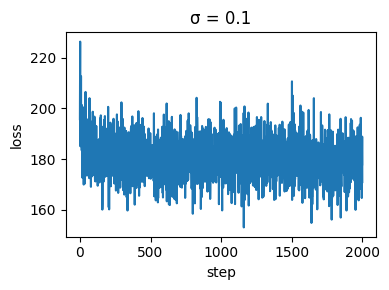

In [8]:
import math

L = len(Ltot)

# on fixe max 4 colonnes par ligne (par ex)
ncols = min(4, L)
nrows = math.ceil(L / ncols)

plt.figure(figsize=(4 * ncols, 3 * nrows))

for i, v in enumerate(Ltot):
    plt.subplot(nrows, ncols, i + 1)
    plt.plot(v[::10])
    plt.title(f"σ = {float(sigmas[i]):.3g}")
    plt.xlabel("step")
    # optionnel: label y sur la première subplot de chaque ligne
    if i % ncols == 0:
        plt.ylabel("loss")

plt.tight_layout()
plt.show()


In [9]:
B = 5000
L_sigma = []

       
j = 0
for s in sigmas : 
    model = models[j].eval()
    sigma = s.expand(B).unsqueeze(-1)
    x = dataset.sample((B,))
    eps = torch.randn_like(x).to(device)
    x_noisy = x + sigma* eps # donc B écahntillons bruité 

    score = model(x_noisy)
    if EPS_TRAINNING:
        target = - eps
    else : 
        target = -eps/sigma
    mse_i = ((score - target)**2).sum(dim=-1, keepdim=True)  # (B,1)
    mse_mean = mse_i.mean().item()

    target_norm_mean = (target**2).sum(dim=-1).mean()
    relative_error = mse_mean/target_norm_mean
    
    print(f'loss for sigma = {s:.2f} : {mse_mean:.3f}')
    print(f'target mean = {target_norm_mean:.3f} | theorique : {x.shape[-1]/s**2 :.3f}')
    print(f'erreur relative : {100* relative_error:.2f}%')
    j+=1
            


loss for sigma = 0.10 : 181.717
target mean = 200.809 | theorique : 200.000
erreur relative : 90.49%


In [10]:

@torch.no_grad()
def annealded_langevin_sampler(prior,noisy_distrib_scores,noise_factor,step_size,T,n_chain):
    X = prior.sample((n_chain,)).to(device)
    U = dist.MultivariateNormal(loc = t([0,0]),covariance_matrix=torch.eye(2,device=device))
    for i in range(len(noisy_distrib_scores)):
        tau = step_size * noise_factor[i]
        for _ in range(T):
            X = X + tau*noisy_distrib_scores[i](X) + torch.sqrt(t(2*tau))*U.sample((n_chain,))
    return X  


In [11]:
def score(distrib,x):
    x = x.clone().detach().requires_grad_(True)
    lp = distrib.log_prob(x)
    score, = torch.autograd.grad(lp.sum(),x) # lp.sum() pour que si x a un batch_size ça marche.
    return score

def plot_scores_as_vectors(true_score,estimated_score,sigmas):
    # true score : list of scores(x)
    # estimated score : list of scores(x)
    n_points = 20
    x_min,x_max = -10,10
    xc = torch.linspace(x_min,x_max,n_points,device=device)
    yc = torch.linspace(x_min,x_max,n_points,device=device)
    
    X,Y = torch.meshgrid([xc,yc],indexing='ij')
    coords = torch.stack([X, Y], dim=-1)      # (n_points, n_points, 2)
    coords_flat = coords.view(-1, 2)          # (B, 2) avec B = n_points**2
    B = coords_flat.shape[0]
    nrows = len(sigmas)
    fig, axes = plt.subplots(nrows=nrows, ncols=2,
                         figsize=(10, 4*nrows),
                         squeeze=False)
    
    for i,s in enumerate(sigmas) : 
        
        true_score_flat_i = true_score[i](coords_flat)
        estimated_score_flat_i = estimated_score[i](coords_flat)
        
        true_score_i = true_score_flat_i.view(n_points, n_points, 2)
        estimated_score_i = estimated_score_flat_i.view(n_points,n_points,2)  
        
        Sx_TS = true_score_i[...,0].cpu().detach()
        Sy_TS = true_score_i[...,1].cpu().detach()
        Sx_ES = estimated_score_i[...,0].cpu().detach()
        Sy_ES = estimated_score_i[...,1].cpu().detach()
        
        X_cpu = X.cpu()
        Y_cpu = Y.cpu()

        ax_true = axes[i, 0]
        ax_est  = axes[i, 1]

        ax_true.set_xlim(x_min, x_max)
        ax_true.set_ylim(x_min, x_max)
        h = np.log(25)/nrows
        scale1 = 0.5 + 25*i/nrows
        scale2 = 0.5 + -1 +  np.exp(h*i)
        ax_true.quiver(X_cpu, Y_cpu, Sx_TS, Sy_TS,angles='xy', scale_units='xy', scale=scale1) # j'adapte juste le rescaling pour que l'on voit quelque chose à toute les échelles
        ax_true.set_aspect('equal')
        ax_true.set_title(f"True Score, sigma={float(s):.3f}")

        ax_est.set_xlim(x_min, x_max)
        ax_est.set_ylim(x_min, x_max)
        ax_est.quiver(X_cpu, Y_cpu, Sx_ES, Sy_ES, angles='xy', scale_units='xy', scale=scale1)
        ax_est.set_aspect('equal')
        ax_est.set_title(f"Estimated Score, sigma={float(s):.3f}")
        
    plt.show()  

def plot_scores_norm(true_score,estimated_score,sigmas):
    # true score : list of scores(x)
    # estimated score : list of scores(x)
    n_points = 100
    x_min,x_max = -10,10
    xc = torch.linspace(x_min,x_max,n_points,device=device)
    yc = torch.linspace(x_min,x_max,n_points,device=device) 
    X,Y = torch.meshgrid([xc,yc],indexing='ij')
    coords = torch.stack([X, Y], dim=-1)      # (n_points, n_points, 2)
    coords_flat = coords.view(-1, 2)          # (B, 2) avec B = n_points**2
    B = coords_flat.shape[0]
    nrows = len(sigmas)
    fig, axes = plt.subplots(nrows=nrows, ncols=2,
                         figsize=(10, 4*nrows),
                         squeeze=False)
    
    for i,s in enumerate(sigmas) : 
        
        true_score_flat_i = true_score[i](coords_flat)
        estimated_score_flat_i = estimated_score[i](coords_flat)
        
        true_score_i = true_score_flat_i.view(n_points, n_points, 2)
        estimated_score_i = estimated_score_flat_i.view(n_points,n_points,2)  
        mag_ts = torch.linalg.norm(true_score_i, dim=-1).cpu()
        mag_es = torch.linalg.norm(estimated_score_i, dim=-1).cpu().detach()
        eps = 1e-8
        log_mag_ts = (mag_ts + eps).log10()
        log_mag_es = (mag_es + eps).log10()
        
        
        X_cpu = X.cpu()
        Y_cpu = Y.cpu()

        ax_true = axes[i, 0]
        ax_est  = axes[i, 1]

        ax_true.set_xlim(x_min, x_max)
        ax_true.set_ylim(x_min, x_max)
        im0 = ax_true.imshow(
        log_mag_ts,
        origin='lower',
        extent=[x_min, x_max, x_min, x_max]
        )
        
        ax_true.set_title(f"||True score||, sigma={float(s):.2f}")
        plt.colorbar(im0, ax=ax_true)
        
        ax_est.set_xlim(x_min, x_max)
        ax_est.set_ylim(x_min, x_max)
        im1 = ax_est.imshow(
        log_mag_es,
        origin='lower',
        extent=[x_min, x_max, x_min, x_max]
        )
        ax_est.set_title(f"||Estimated Score||, sigma={float(s):.2f}")
        plt.colorbar(im1, ax=ax_est)

    plt.show() 

def construct_GMM_noised_distribution(noise_list,loc,cov,weights):
    d = loc.size(-1)
    noised_distribution = []
    for sigma in noise_list : 
        g_noised = dist.MultivariateNormal(loc,cov + torch.eye(d,device=device)*sigma**2)
        noised_distribution.append(dist.MixtureSameFamily(weights,g_noised))
    return noised_distribution

def make_true_score(d):
    return lambda x: score(d, x)

def make_score_from_model(model, sigma_scalar,eps_loss = False):
    sigma_scalar = float(sigma_scalar)
    def score(x):
        # x: (B, x_dim)
        B = x.shape[0]
        sigma = x.new_full((B, 1), sigma_scalar)   # (B,1) 
        return model(x)
    def score_eps(x):
       # x: (B, x_dim)
        B = x.shape[0]
        sigma = x.new_full((B, 1), sigma_scalar)   # (B,1) 
        return model(x) /sigma
    if eps_loss : 
        return score_eps
    else : 
        return score


In [12]:


true_noised_dist = construct_GMM_noised_distribution(noise_list=sigmas,loc=mean,cov=cov,weights=weights)
true_distribution_scores = [make_true_score(d) for d in true_noised_dist]
estimated_distribution_scores = [make_score_from_model(model,noise,EPS_TRAINNING) for noise in list(sigmas)]

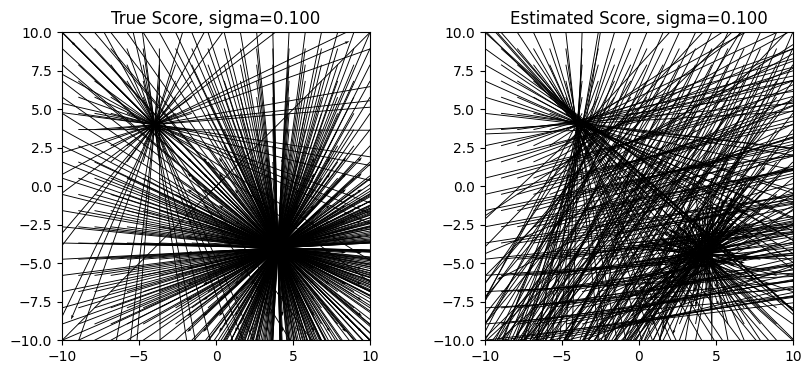

In [13]:
plot_scores_as_vectors(true_distribution_scores,estimated_distribution_scores,sigmas)

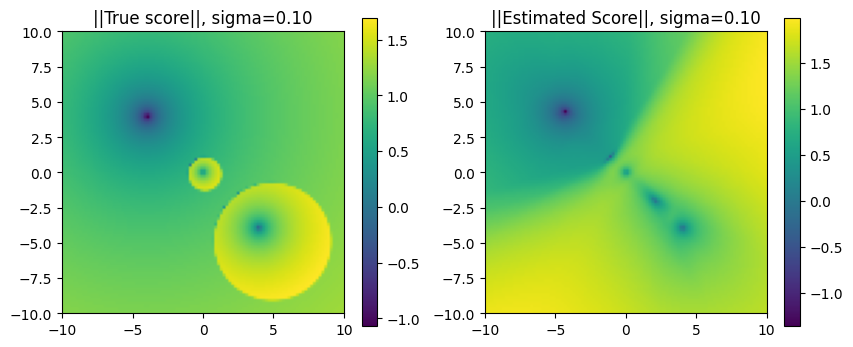

In [14]:
plot_scores_norm(true_distribution_scores,estimated_distribution_scores,sigmas)

In [15]:

prior_mean = t([0,0])
prior_var = torch.eye(2).to(device)
prior_distrib = dist.MultivariateNormal(prior_mean,covariance_matrix=prior_var)

n_chain = 2000
A_langevin_samples = annealded_langevin_sampler(prior_distrib,estimated_distribution_scores,sigmas,t(0.2),3000,n_chain)


In [16]:
true_samples = dataset.sample((n_chain,)).cpu()
ALD = A_langevin_samples.cpu()

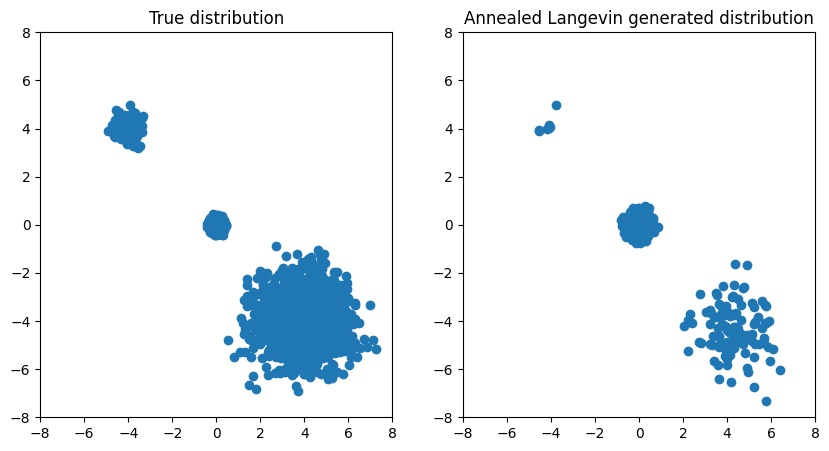

In [17]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.scatter(true_samples.T[0],true_samples.T[1])
plt.title("True distribution")
plt.subplot(1,2,2)
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.title('Annealed Langevin generated distribution')
plt.scatter(ALD.T[0],ALD.T[1])
plt.show()